![](https://media1.tenor.com/images/187aa2e92e2dbbef3877cd9a8481a91b/tenor.gif?itemid=9005495)

## Why do we need Mask Detection?
In these uncertain times, human civilization needs to quickly adapt to the threat at hand. While wearing mask is not the ultimate solution, it still reduces the rate of transmission of the virus. For us, to create such safe ecosystem, we need techniques like Mask Detection to ensure that the rate of transmission is controlled in highly crowded public spaces and other areas where risk of transmission is high.

In this notebook, following process is adopted:
* Step1: Extract the face data for training.
* Step2: Train the classifier to classify faces into mask or non-mask labels.
* Step3: Detect Faces in testing data using SSD Face Detector.
* Step4: By using the trained classifier, classify the detected faces.

## Content
1.[Importing Libraries and Directories](#section-one)
2.[What is SSD?](#section-two)
3.[Functions](#section-three) 
4.[Data Preprocessing](#section-four)
5.[Model Architecture and Training Process](#section-five)
6.[Training and Validation Visualizations](#section-six)
7.[Model Testing](#section-seven)
8.[Conclusion](#section-eight)

<a id="section-one"></a>
## Importing Libraries and Directories

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

Using TensorFlow backend.


<a id="section-two"></a>
## What is SSD?
SSD is **Single Shot Multibox Detector**. It is a technique that is used to detect objects in images using a single deep neural network. Basically its used for object detection in an image. By using a **base architecture of VGG-16 Architecture**, SSD is able to out perform other object detectors like YOLO and Faster R-CNN in both speed and accuracy. The architecture of SSD is given in the figure below. Training a SSD model from scratch will require a lot of data, so here I have imported pretrained weights **(Caffe Face Detector Model)** using OpenCV.

![SSD Architecture](https://www.researchgate.net/profile/Adam_Nowosielski/publication/332948824/figure/fig5/AS:767146284036100@1559913335810/The-model-of-Single-Shot-MultiBox-Detector-SSD-25.ppm)

In [2]:
cvNet = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

<a id="section-three"></a>
## Functions 
1. JSON Function fetches the json file that has the data of bounding box in the training dataset.
2. Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems. In simple terms it is used to instill some light in the image. If gamma < 1, image will shift towards darker end of the spectrum and when gamma > 1, there will be more light in the image.

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

<a id="section-four"></a>
## Data Preprocessing 

Lets look at the JSON data given for training:
* The Annotations field contains the data of all the faces present in a particular image.
* There are various classnames but the true classnames are **face_with_mask** and **face_no_mask**.

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df.head()

name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask

* By using the mask label and non_mask label, the bounding box data from json files is extracted.
* The faces from any particular image are extracted and stored in the data list along with its label for the training process.

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

In [8]:
len(data)

5749

* The visualization below tells us that the **Number of Mask images > Number of Non-Mask images**, so this is an imbalanced dataset. But since we are using a SSD pretrained model, which is trained to detect non-mask faces, this imbalance would not matter a lot.

In [9]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)


In [11]:
X[0].shape

(124, 124, 3)

In [12]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [13]:
np.unique(Y)

array([0, 1])

In [14]:
Y.shape

(5749,)

<a id="section-five"></a>
## Model Architecture and Training Process 

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 460800)           

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [18]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [20]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50
143/143 [==============================] - 18s 125ms/step - loss: 0.4691 - accuracy: 0.8393 - val_loss: 0.2659 - val_accuracy: 0.8974
Epoch 2/50
143/143 [==============================] - 16s 112ms/step - loss: 0.2778 - accuracy: 0.8835 - val_loss: 0.2297 - val_accuracy: 0.9104
Epoch 3/50
143/143 [==============================] - 15s 108ms/step - loss: 0.2639 - accuracy: 0.8956 - val_loss: 0.2215 - val_accuracy: 0.9165
Epoch 4/50
143/143 [==============================] - 16s 112ms/step - loss: 0.2451 - accuracy: 0.8934 - val_loss: 0.2508 - val_accuracy: 0.8904
Epoch 5/50
143/143 [==============================] - 16s 109ms/step - loss: 0.2390 - accuracy: 0.9056 - val_loss: 0.1932 - val_accuracy: 0.9296
Epoch 6/50
143/143 [==============================] - 16s 110ms/step - loss: 0.2352 - accuracy: 0.9118 - val_loss: 0.2300 - val_accuracy: 0.9183
Epoch 7/50
143/143 [==============================] - 15s 107ms/step - loss: 0.2254 - accuracy: 0.9089 - val_loss: 0.2068 - val_ac

<a id="section-six"></a>
## Training and Validation Visualizations

In [21]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

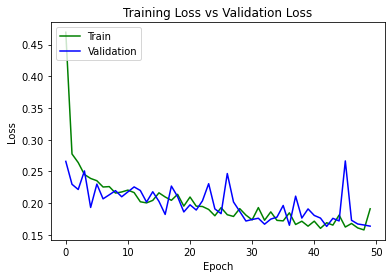

In [22]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id="section-seven"></a>
## Model Testing 

The test dataset has 1698 images and to evaluate the model I have taken a handful of images from this dataset as there are no labels for faces in the dataset. 

In [23]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [24]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

* Gamma Correction for making the image appear in more light.**(Gamma = 2)**
* blobFromImage creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels. [Refer OpenCV documentation]
* The blob is passed through the SSD network and detections are made with some confidence score.
* Define a threshold confidence score, above which the detection will be considered as a candidate of being a face. (In this case **confidence threshold = 0.2**)
* All the detections that qualify the confidence score are then passed to the architecture for classification into mask or non-mask image.

In [25]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

<a id="section-eight"></a>
## Conclusion
By analyzing the results it can be observed that the whole system works well for faces that have spatial dominance i.e. in image at (1,1), (1,2) and (2,1) but fails in case of (2,2) where the faces are small and occupy less space in the overall image. **To get better results, different image preprocessing techniques can be used, or confidence threshold can be kept lower, or one can try different blob size.**

If you liked this notebook, then do **Upvote** as it will keep me motivated in creating such kernels ahead. **Thanks!!**